In [47]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import integrate
import matplotlib.pyplot as pl
import matplotlib as mpl
import pysynphot as S
mpl.rc('font',**{'family':'serif','serif':['Palatino']})
%config InlineBackend.figure_formats = {'png', 'retina'}
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15

In [128]:
file = np.loadtxt("files/cp_skybg_zm_23_10_ph.dat")  # ph/sec/arcsec^2/nm/m^2
file2 = np.loadtxt("files/cp_skybg_zm_23_20_ph.dat")
file3 = np.loadtxt("files/cp_skybg_zm_100_10_ph.dat")
file4 = np.loadtxt("files/cp_skybg_zm_100_20_ph.dat")

transky1 = np.loadtxt("files/cptrans_zm_23_10.dat")
transky2 = np.loadtxt("files/cptrans_zm_100_20.dat")

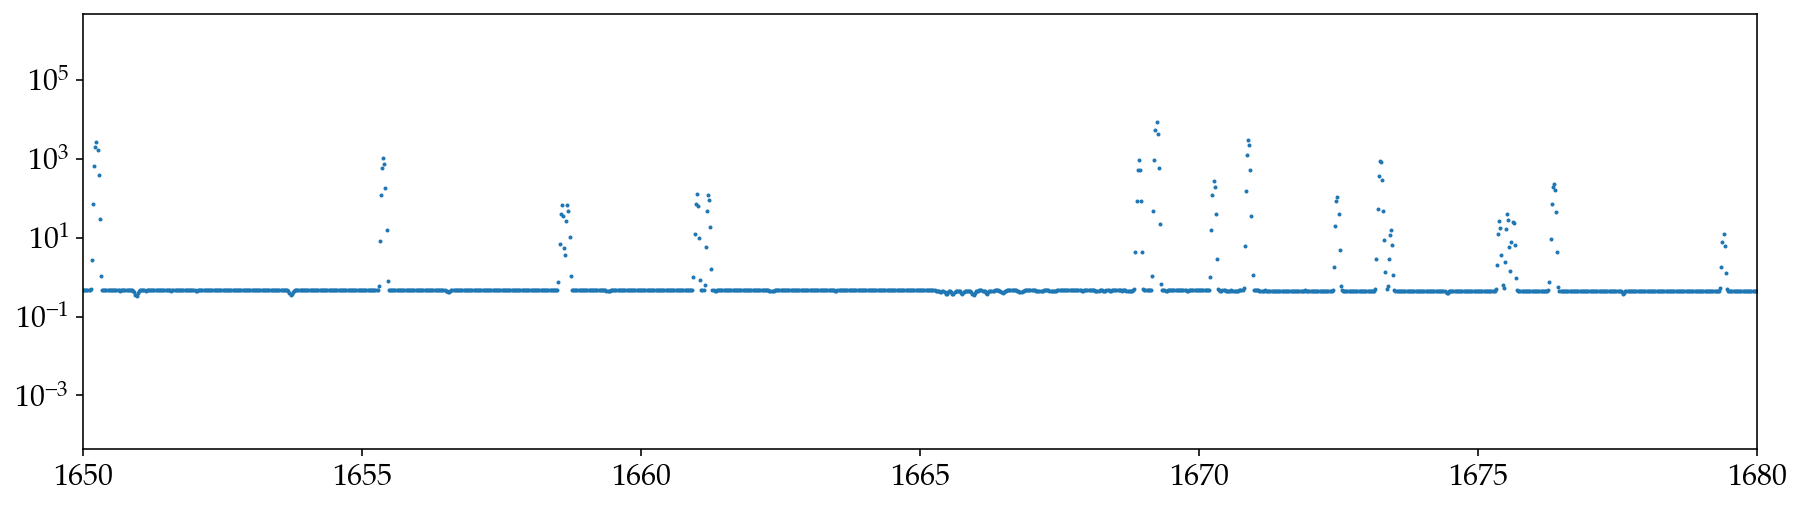

In [83]:
pl.subplots(figsize=(15,4))
pl.scatter(file.T[0],file.T[1],s=1)
#pl.xlim(1500,1800)
pl.xlim(1650,1680)
pl.yscale("log")
pl.show()

In [129]:
print(transky1)

[[0.9       0.998654 ]
 [0.90002   0.99856  ]
 [0.90004   0.998536 ]
 ...
 [5.59994   0.0586665]
 [5.59996   0.057324 ]
 [5.59998   0.0559527]]


In [202]:
wl = np.arange(900,5601,1)
def binning(x,y,wl):
    y_new=np.array([])
    x = np.array(x)
    y = np.array(y)
    for wl_tmp in wl:
        y_sum=0
        in_index = np.where(np.logical_and(x<wl_tmp,x>wl_tmp-1))
        y_in  = np.array([])
        for a in in_index:
            y_ = y[in_index]*(x[a]-x[a-1])
            y_in = np.append(y_in,y_)
        y_sum = np.sum(y_in) # binsize
        y_new = np.append(y_new,y_sum)
    return y_new

sky_23_10  = binning(file.T[0],file.T[1],wl)
sky_23_20 = binning(file2.T[0],file2.T[1],wl)
sky_100_10  = binning(file3.T[0],file3.T[1],wl)
sky_100_20 = binning(file4.T[0],file4.T[1],wl)

trans_23_10  = binning(transky1.T[0]*1000,transky1.T[1],wl)
trans_100_20 = binning(transky2.T[0]*1000,transky2.T[1],wl)

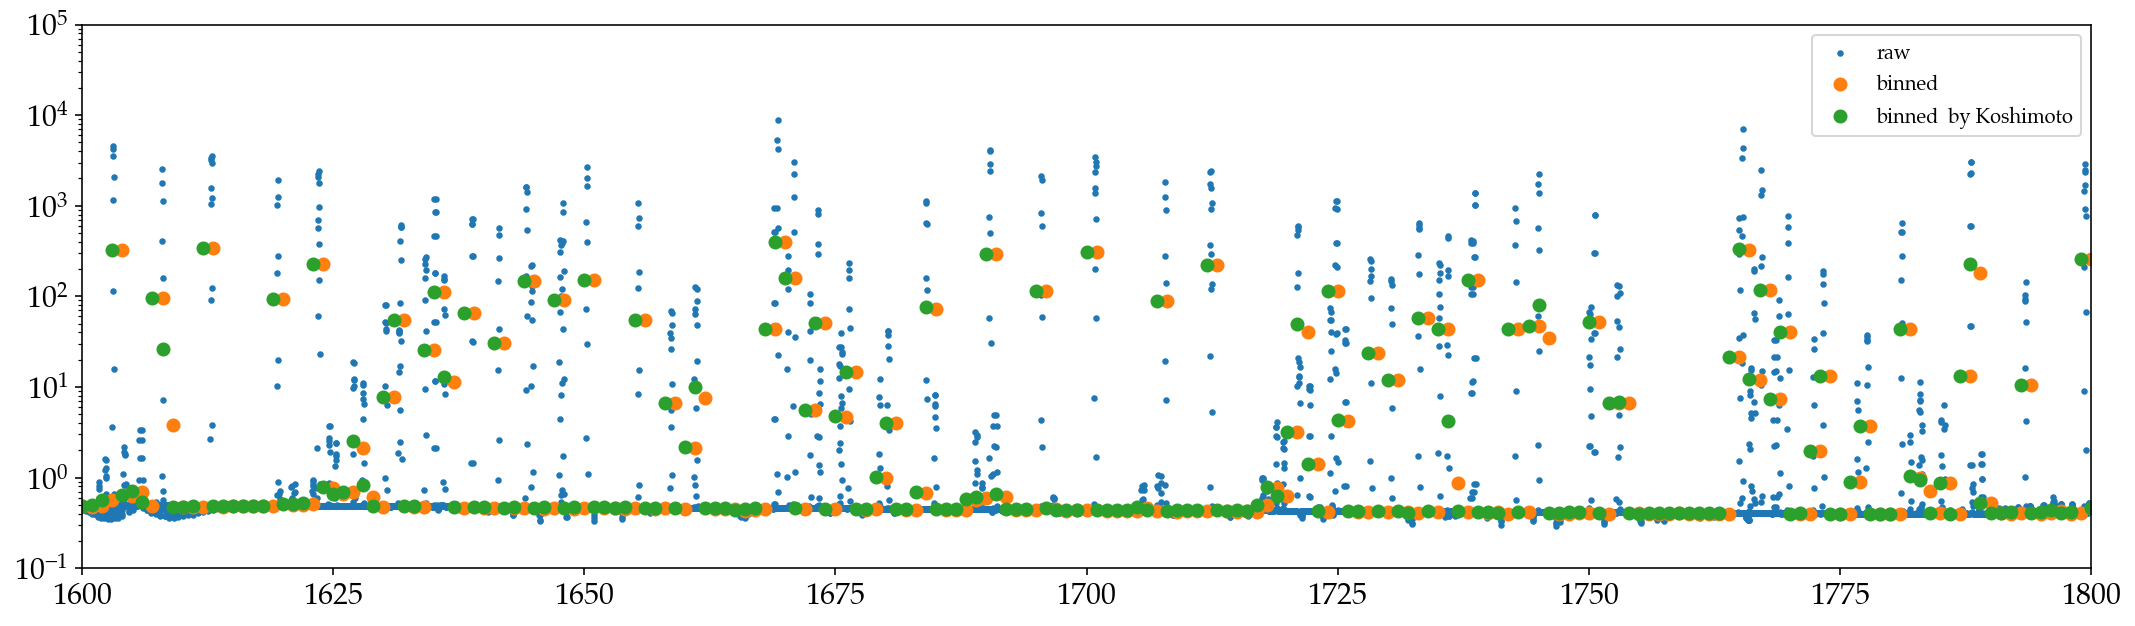

In [203]:
tmp = np.loadtxt("files/skybg_23_10_binned.dat")
pl.subplots(figsize=(18,5))
pl.scatter(file.T[0],file.T[1],s=5,label="raw")
pl.scatter(wl,sky_23_10,label="binned")
pl.scatter(tmp.T[0],tmp.T[1],label="binned  by Koshimoto")
pl.yscale("log")
pl.xlim(1600,1800)
pl.ylim(0.1,1e+5)
pl.legend()
pl.show()

短波長側のデータを加える。

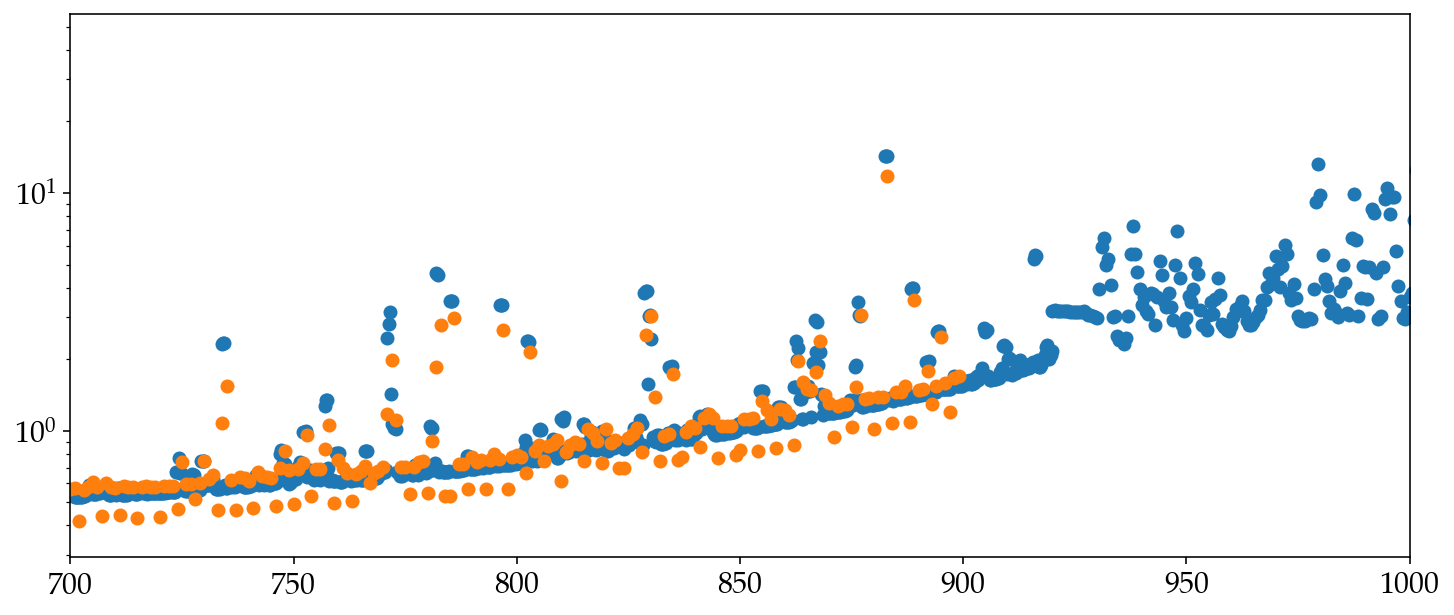

In [205]:
short_sky_file = pd.read_csv("files/skybg_50_10.dat",comment="#",header=None,names=["wl","ph"],delim_whitespace=True) #phot/s/nm/arcsec^2/m^2
wl2 = np.arange(320,900,1)
short_sky = binning(short_sky_file.wl,short_sky_file.ph,wl2)

pl.subplots(figsize=(12,5))
pl.scatter(short_sky_file.wl,short_sky_file.ph)
pl.scatter(wl2,short_sky)
pl.xlim(700,1000)
pl.yscale("log")

In [206]:
WL = np.append(wl2,wl)
sky_23_10_final = np.append(short_sky,sky_23_10)
sky_23_20_final = np.append(short_sky,sky_23_20)
sky_100_10_final = np.append(short_sky,sky_100_10)
sky_100_20_final = np.append(short_sky,sky_100_20)

trans_23_10_final = np.append(np.ones(len(wl2)),trans_23_10)
trans_100_20_final = np.append(np.ones(len(wl2)),trans_100_20)

In [207]:
np.save("files/cp_skybg_zm_23_10_ph_bin",np.array([WL,sky_23_10_final]))
np.save("files/cp_skybg_zm_23_20_ph_bin",np.array([WL,sky_23_20_final]))
np.save("files/cp_skybg_zm_100_10_ph_bin",np.array([WL,sky_100_10_final]))
np.save("files/cp_skybg_zm_100_20_ph_bin",np.array([WL,sky_100_20_final]))
np.save("files/cp_trans_zm_23_10_ph_bin",np.array([WL,trans_23_10_final]))
np.save("files/cp_trans_zm_100_20_ph_bin",np.array([WL,trans_100_20_final]))

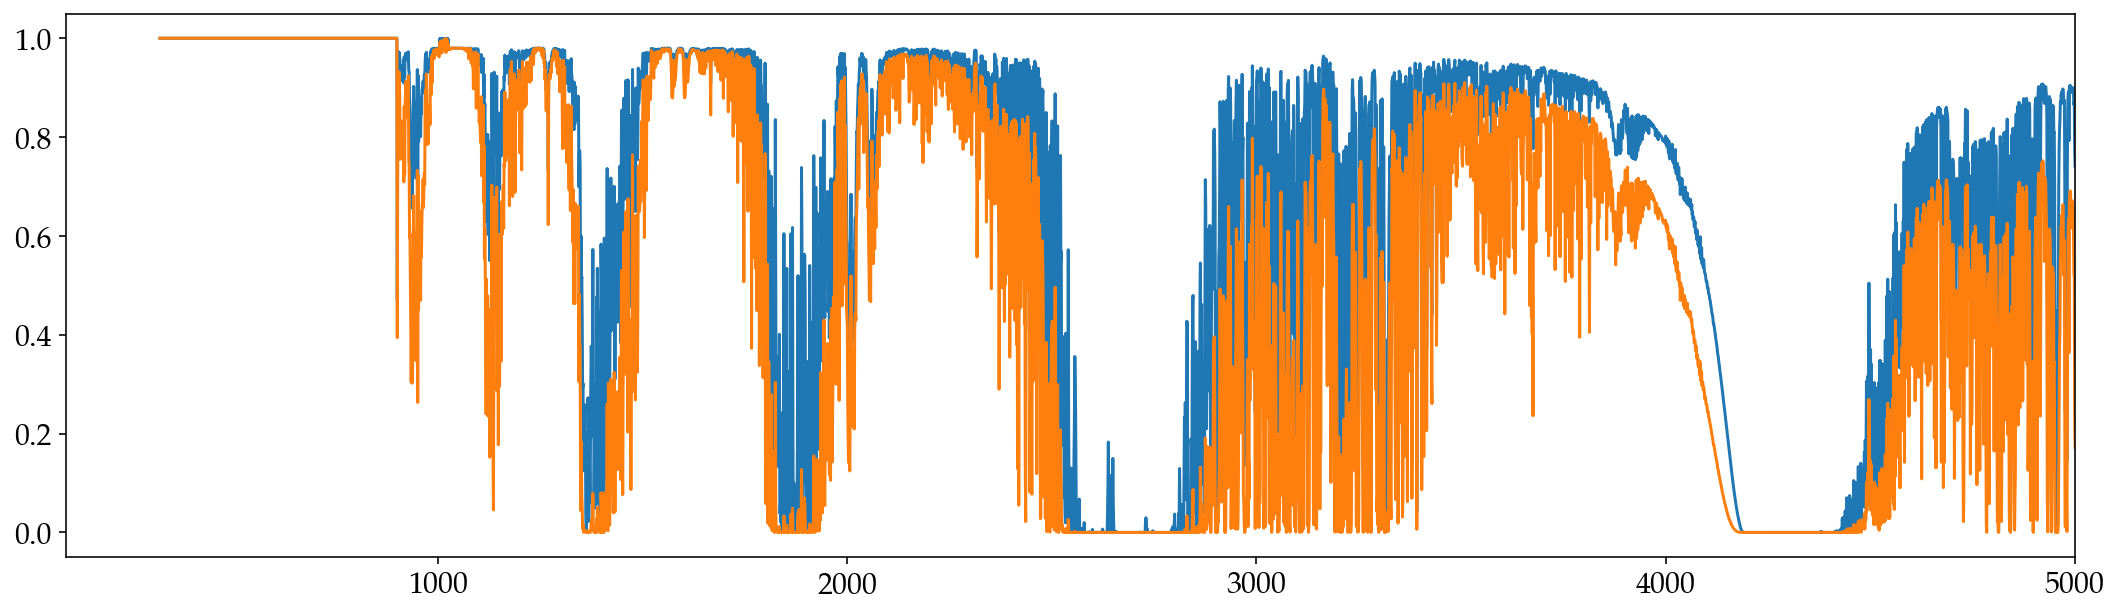

In [172]:
Vega = np.loadtxt("files/Vega_stis_008.dat",comments="#") # [erg/s/cm2/A]
NM = Vega.T[0]*0.1 
def erg_cm2_A_to_ph_m2_nm(nm,spectrum):
    h_cons = 6.62607876*1e-27      # [erg s]
    c_cons = 2.99792458*1e+8       # [m/s]
    hc = h_cons*c_cons             # [erg m]
    hv = hc/(nm*1e-9)              # [erg/photons]         
    photons = spectrum*10/hv*1e+4 # [photons/s/m2/nm]
    return photons
photons = erg_cm2_A_to_ph_m2_nm(NM,Vega.T[1])

pl.subplots(figsize=(18,5))
#pl.plot(NM,photons)
pl.plot(WL,trans_23_10_final)
pl.plot(WL,trans_100_20_final)
pl.xlim(90,5000)
#pl.yscale("log")
#pl.legend()
pl.show()

In [18]:
sky = np.load("files/cp_skybg_zm_23_10_ph_bin.npy")
print(sky)
print(file.T[1][:25].sum())
print(sky[1][0])
print(file.T[1][25:75].sum())
print(sky[1][1])

[[3.20000000e+02 3.21000000e+02 3.22000000e+02 ... 5.59700000e+03
  5.59800000e+03 5.59900000e+03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.67652031e+05
  6.29014210e+05 8.01892476e+05]]
99.72294059999999
0.0
59.55384790000001
0.0


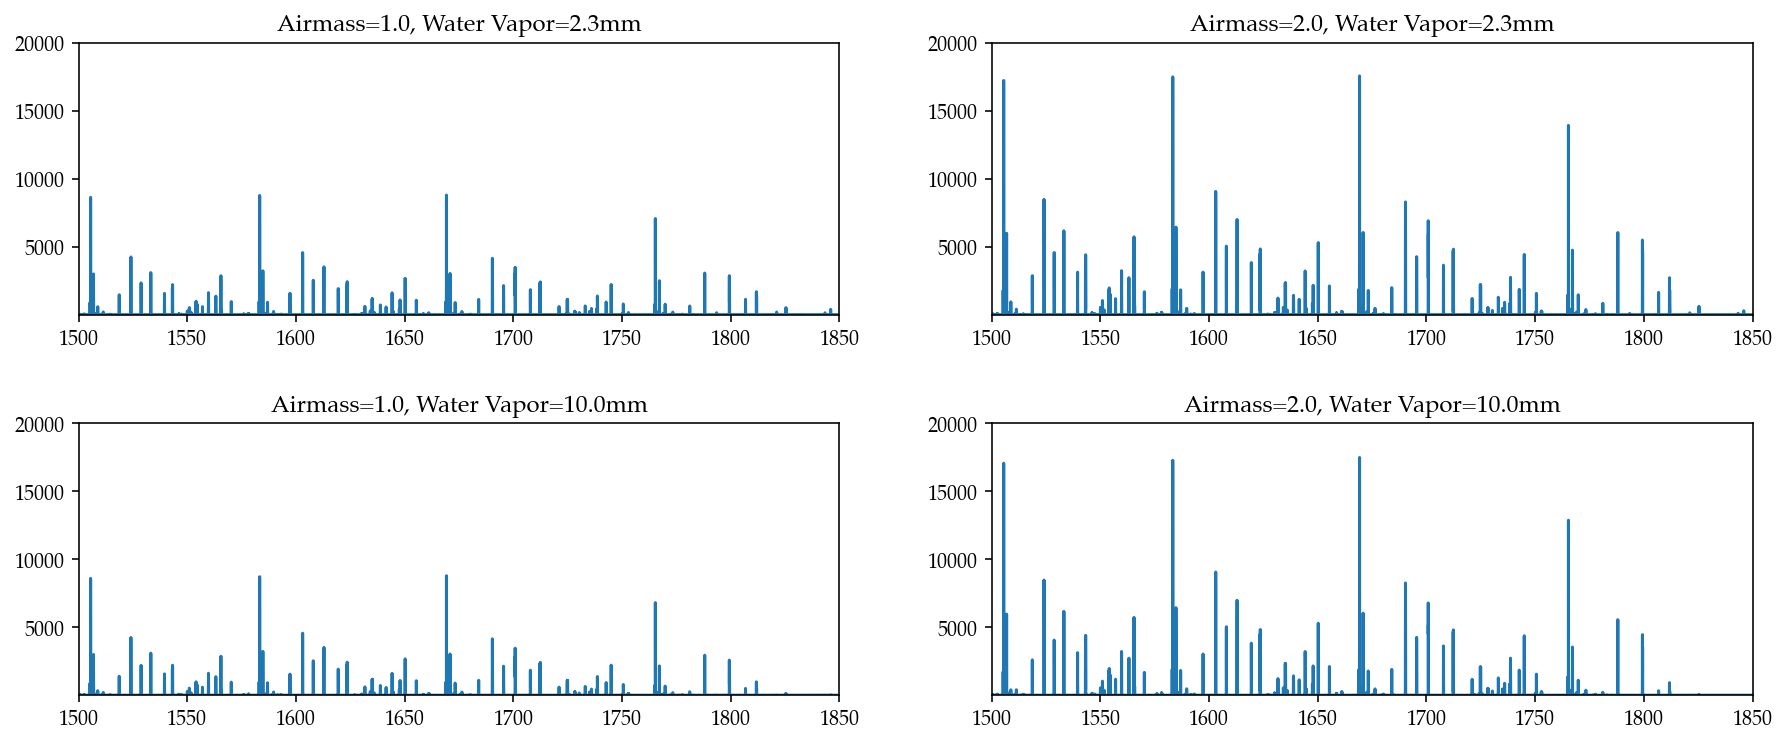

In [19]:
if(1):
    xmin=1500
    xmax=1850
    ymin=1e-1
    ymax=2e+4

    fig,ax=pl.subplots(2,2,figsize=(15,6))
    fig.subplots_adjust(wspace=0.2,hspace=0.4)
    ax[0][0].plot(file.T[0],file.T[1])
    ax[0][0].set_ylim(ymin,ymax)
    ax[0][0].set_xlim(xmin,xmax)
    #ax[0][0].set_yscale("log")
    ax[0][0].set_title("Airmass=1.0, Water Vapor=2.3mm")
    ax[0][1].plot(file2.T[0],file2.T[1])
    ax[0][1].set_ylim(ymin,ymax)
    ax[0][1].set_xlim(xmin,xmax)
    #ax[0][1].set_yscale("log")
    ax[0][1].set_title("Airmass=2.0, Water Vapor=2.3mm")
    ax[1][0].plot(file3.T[0],file3.T[1])
    ax[1][0].set_ylim(ymin,ymax)
    ax[1][0].set_xlim(xmin,xmax)
    #ax[1][0].set_yscale("log")
    ax[1][0].set_title("Airmass=1.0, Water Vapor=10.0mm")
    ax[1][1].plot(file4.T[0],file4.T[1])
    ax[1][1].set_ylim(ymin,ymax)
    ax[1][1].set_xlim(xmin,xmax)
    #ax[1][1].set_yscale("log")
    ax[1][1].set_title("Airmass=2.0, Water Vapor=10.0mm")
    pl.savefig("/Users/shotamiyazaki/Desktop/Sky_variation.pdf",dpi=200,bbox_inches="tight")